In [1]:
import pandas as pd
import numpy as np
import re
import json
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [3]:
punctuations = string.punctuation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

In [4]:

def spacy_tokenizer(sent):
    tokens = parser(sent)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    return tokens


def clean_text(text):
    return text.strip().lower()

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def run_model(X_train, X_test, y_train, y_test, clf):
    tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
    #clf.fit(X_train, y_train)
    model = Pipeline([
                    ("cleaner", predictors()),
                    ('vectorizer', tfidf_vector),
                    ('classifier', clf)
                    ])


    model.fit(X_train,y_train)
    return model

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
    #pred_y = model.predict(X_test)
    #mostrar_resultados(y_test, pred_y)



In [5]:
with open("_data/reviews.json", encoding='utf-8', errors='ignore') as json_data:
     data = json.load(json_data, strict=False)

In [6]:
fix = [v for v in data['reviews']]

In [7]:
reviews=pd.DataFrame.from_dict(fix, orient='columns', dtype=None, columns=None)

In [8]:
reviews.head()

#reviews.info()

#reviews.stars.value_counts()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [10]:
"""
Excluyo los neutros. 
"""

'\nExcluyo los neutros. Quizàs se overfittea. \n'

In [9]:
neutral_reviews = reviews[reviews.stars == 3]
reviews = reviews[reviews.stars != 3]

In [10]:
reviews['sentiment'] = np.where(reviews.stars>3, 1, 0)

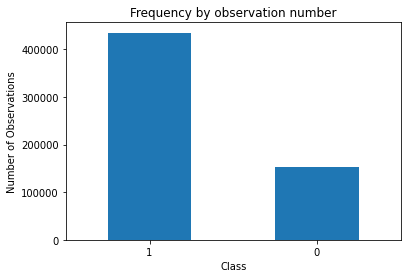

In [11]:
count_classes = pd.value_counts(reviews['sentiment'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [12]:
"""
Genero dos modelitos con estos datosa
"""

'\nGenero dos modelitos con estos datosa\n'

In [14]:
clf_balanced = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
clf_unbalanced = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")

#clf.classes_

In [15]:
X = reviews['text']
ylabels = reviews['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)


In [16]:
model_a = run_model(X_train, X_test, y_train, y_test, clf_balanced)
pred_y_model_a = model_a.predict(X_test)


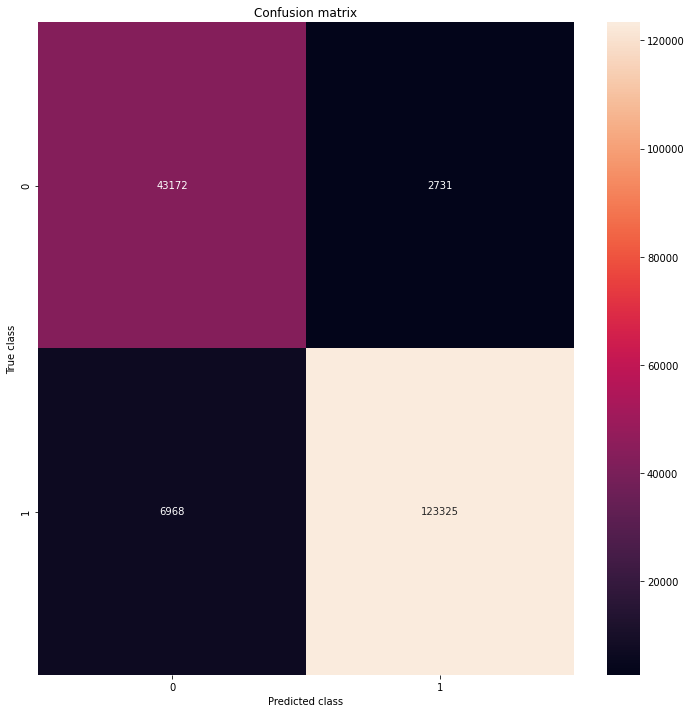

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     45903
           1       0.98      0.95      0.96    130293

    accuracy                           0.94    176196
   macro avg       0.92      0.94      0.93    176196
weighted avg       0.95      0.94      0.95    176196



In [17]:
show_results(y_test, pred_y_model_a)

In [ ]:
"""
Balanced Results
             precision    recall  f1-score   support

           0       0.86      0.94      0.90     45810
           1       0.98      0.95      0.96    130386

    accuracy                           0.95    176196
   macro avg       0.92      0.94      0.93    176196
weighted avg       0.95      0.95      0.95    176196
"""

In [16]:
model_b = run_model(X_train, X_test, y_train, y_test, clf_unbalanced)
pred_y_model_b = model_b.predict(X_test)

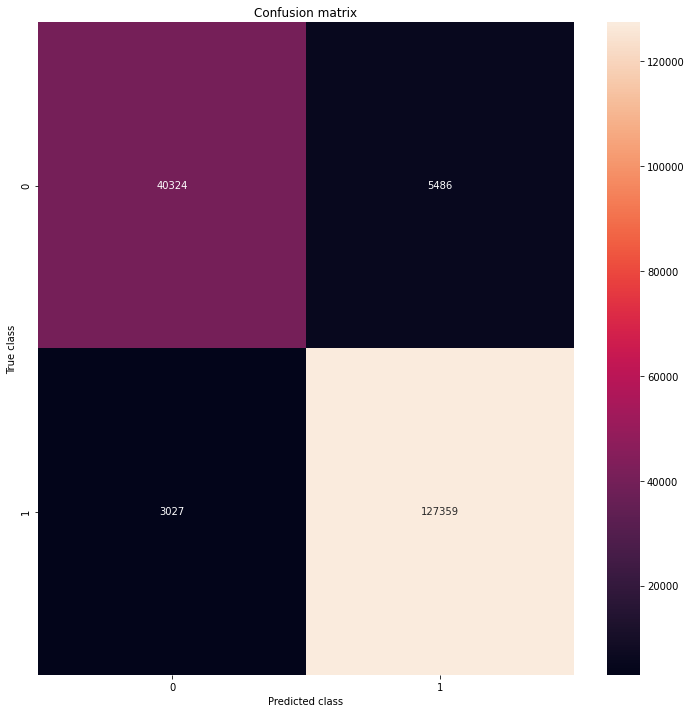

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     45810
           1       0.96      0.98      0.97    130386

    accuracy                           0.95    176196
   macro avg       0.94      0.93      0.94    176196
weighted avg       0.95      0.95      0.95    176196



In [17]:
show_results(y_test, pred_y_model_b)

In [18]:
from sklearn import metrics
# Predicting with a test dataset
#predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, pred_y_model_a))
print("Logistic Regression Precision:",metrics.precision_score(y_test, pred_y_model_a))
print("Logistic Regression Recall:",metrics.recall_score(y_test, pred_y_model_a))

Logistic Regression Accuracy: 0.9449533474085677
Logistic Regression Precision: 0.9783350257028622
Logistic Regression Recall: 0.9465205344876547


In [19]:
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, pred_y_model_b))
print("Logistic Regression Precision:",metrics.precision_score(y_test, pred_y_model_b))
print("Logistic Regression Recall:",metrics.recall_score(y_test, pred_y_model_b))

Logistic Regression Accuracy: 0.9516844877295739
Logistic Regression Precision: 0.9587037524935075
Logistic Regression Recall: 0.9767843173346832


In [19]:
import pickle

filename = 'LR_blanced_model'
pickle.dump(model_a, open(filename, 'wb'))

In [21]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9449533474085677


In [ ]:
#Balanced

In [22]:
test1 = model_a.predict(["I hate it, they were not too nice people", "I loved it, they were too nice people"])

In [23]:
result

array([0, 1])

In [24]:
#Unbalanced
model_b.predict(["I hate it, they were not too nice people", "I loved it, they were too nice people"])

array([1, 1])